<h2 style='color:blue' align='center'>Image Classification<h2>

In [1]:
cropped_image_dirs = ['./dataset/cropped/BillGates', './dataset/cropped/jin ping', './dataset/cropped/Kim jong un', './dataset/cropped/Fidel Castro', 
 './dataset/cropped/Obama', './dataset/cropped/putin', './dataset/cropped/Trump', './dataset/cropped/Modi', 
 './dataset/cropped/Nelson mandela', './dataset/cropped/joe biden']

In [2]:
import numpy as np
import cv2
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

print('done')
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1200)])
  except RuntimeError as e:
    print('error --> ', e)
print('done')


2023-11-17 04:54:08.686779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


done
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
done


2023-11-17 04:54:10.882655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 04:54:10.894156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 04:54:10.897128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>

#### Now how do you detect face and eyes?

We will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

In [4]:
'***'
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [5]:
'***'
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    # print(coeffs_H.shape)
    # print(len(coeffs_H))
    
    # coeffs_H[0] *= 0;
    coeffs_H[0] *= 0;
    

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [6]:
'***'
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 0:
            return roi_color

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

### Manually examine cropped folder and delete any unwanted images

In [7]:
'*** '
'*** '
celebrity_file_names_dict = {}
# cropped_image_dirs = ['./dataset/cropped/jin ping', './dataset/cropped/Kim jong un', 
#  './dataset/cropped/Fidel Castro', './dataset/cropped/Obama', './dataset/cropped/putin', 
#  './dataset/cropped/Modi']

for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'BillGates': ['./dataset/cropped/BillGates/BillGates17.png',
  './dataset/cropped/BillGates/BillGates12 (copy).png',
  './dataset/cropped/BillGates/BillGates10 (copy).png',
  './dataset/cropped/BillGates/BillGates2 (copy).png',
  './dataset/cropped/BillGates/BillGates18.png',
  './dataset/cropped/BillGates/BillGates22 (copy).png',
  './dataset/cropped/BillGates/BillGates19.png',
  './dataset/cropped/BillGates/BillGates8.png',
  './dataset/cropped/BillGates/BillGates4.png',
  './dataset/cropped/BillGates/BillGates5 (copy).png',
  './dataset/cropped/BillGates/BillGates26.png',
  './dataset/cropped/BillGates/BillGates22.png',
  './dataset/cropped/BillGates/BillGates29 (copy).png',
  './dataset/cropped/BillGates/BillGates28 (copy).png',
  './dataset/cropped/BillGates/BillGates7 (copy).png',
  './dataset/cropped/BillGates/BillGates11 (copy).png',
  './dataset/cropped/BillGates/BillGates28.png',
  './dataset/cropped/BillGates/BillGates10.png',
  './dataset/cropped/BillGates/BillGates6 (copy

In [8]:
'***'
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
print(class_dict)

{'BillGates': 0, 'jin ping': 1, 'Kim jong un': 2, 'Fidel Castro': 3, 'Obama': 4, 'putin': 5, 'Trump': 6, 'Modi': 7, 'Nelson mandela': 8, 'joe biden': 9}


In [9]:
len(class_dict)

10

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [10]:
'***'
X, y = [], []
k = None
kk = None
kkk = None
kkkk = None

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rss2 = (128, 128)
        scalled_raw_img = cv2.resize(img, rss2)
        scalled_gray_img = cv2.resize(gray, rss2)
        
        img_har = w2d(scalled_raw_img,'db1',5)
        scalled_img_har = cv2.resize(img_har, rss2)
        combined_img = np.hstack((scalled_gray_img, scalled_img_har))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])
        k = combined_img
        kk = scalled_raw_img
        kkk = scalled_img_har
        kkkk = scalled_gray_img
print(len(X))
print(X[0].shape)

736
(128, 256)


(128, 256)


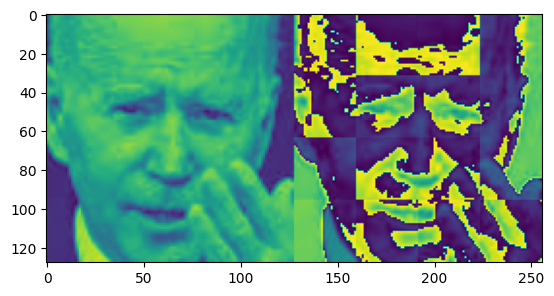

In [11]:
'***'
plt.imshow(k)
print(k.shape)

(128, 128, 3)


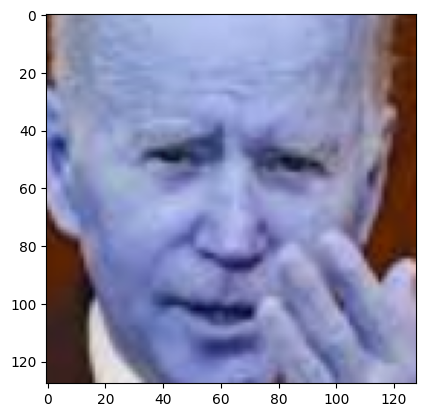

In [12]:
plt.imshow(kk)
print(kk.shape)

(128, 128)


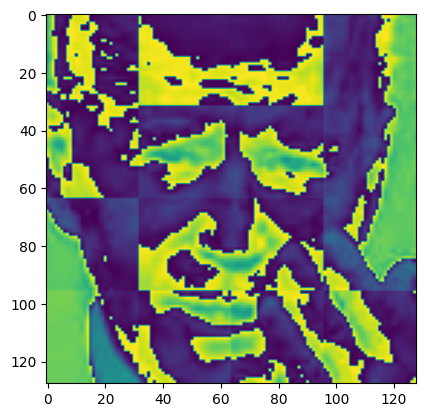

In [13]:
plt.imshow(kkk)
print(kkk.shape)

(128, 128)


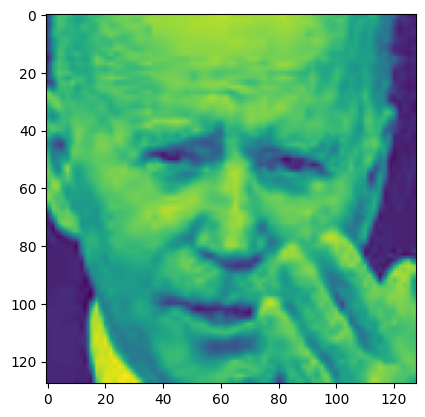

In [14]:
plt.imshow(kkkk)
print(kkkk.shape)

In [15]:
len(X[0])
print(len(X))
print(X[0].shape)
print(X[1].shape)

736
(128, 256)
(128, 256)


In [16]:
'***'
from sklearn.model_selection import train_test_split

X = np.array(X).astype(float)
y = np.array(y).astype(float)
d1 = (-1, 128, 256, 1)
X = np.reshape(X, d1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = X_train / 255.0
X_test = X_test / 255.0
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(552, 128, 256, 1)
(552,)
(184, 128, 256, 1)
(184,)


### Cnn

In [17]:
'***'

input_shape = (128, 256, 1)
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for Dense layers
# model.add(Flatten(input_shape=input_shape))
model.add(Flatten())

# Dense layers with dropout
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer after the first dense layer

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer after the second dense layer

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))  # Dropout layer after the third dense layer

# Output layer
model.add(Dense(len(class_dict), activation='softmax'))


ann = model
# Compile the model

2023-11-17 04:54:38.693033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 04:54:38.696790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 04:54:38.699698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
'***'
print('1 ------------------')
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print('2 ------------------')

1 ------------------
2 ------------------


In [19]:
'***'
print(X_train.shape, y_train.shape)
ann.fit(X_train, y_train, epochs=30)
print('3 ------------------')

(552, 128, 256, 1) (552,)
Epoch 1/30


2023-11-17 04:54:50.119683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2023-11-17 04:54:51.345438: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56409ca971f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-17 04:54:51.345478: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-17 04:54:51.417175: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 7s 117ms/step - loss: 2.2910 - accuracy: 0.1250
Epoch 2/30
18/18 [==============================] - 2s 86ms/step - loss: 2.2612 - accuracy: 0.1703
Epoch 3/30
18/18 [==============================] - 2s 86ms/step - loss: 2.2504 - accuracy: 0.1902
Epoch 4/30
18/18 [==============================] - 2s 86ms/step - loss: 2.2200 - accuracy: 0.2156
Epoch 5/30
18/18 [==============================] - 2s 87ms/step - loss: 2.1841 - accuracy: 0.2572
Epoch 6/30
18/18 [==============================] - 2s 87ms/step - loss: 2.1276 - accuracy: 0.2808
Epoch 7/30
18/18 [==============================] - 2s 87ms/step - loss: 2.0248 - accuracy: 0.3424
Epoch 8/30
18/18 [==============================] - 2s 87ms/step - loss: 1.8831 - accuracy: 0.3551
Epoch 9/30
18/18 [==============================] - 2s 86ms/step - loss: 1.9163 - accuracy: 0.3786
Epoch 10/30
18/18 [==============================] - 2s 87ms/step - loss: 1.6612 - accuracy: 0.4438
Epoch 11/30
18/18 [

In [20]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

# {'jin ping': 0, 'Kim jong un': 1, 'Fidel Castro': 2, 'Obama': 3, 'putin': 4, 'Modi': 5}
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

6/6 [==============================] - 1s 81ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        19
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        18
         3.0       1.00      1.00      1.00        17
         4.0       1.00      1.00      1.00        29
         5.0       1.00      1.00      1.00        11
         6.0       0.91      1.00      0.95        20
         7.0       1.00      1.00      1.00        21
         8.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        24

    accuracy                           0.99       184
   macro avg       0.99      0.99      0.99       184
weighted avg       0.99      0.99      0.99       184



In [21]:
import json
print(class_dict)
print(list(class_dict))
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

{'BillGates': 0, 'jin ping': 1, 'Kim jong un': 2, 'Fidel Castro': 3, 'Obama': 4, 'putin': 5, 'Trump': 6, 'Modi': 7, 'Nelson mandela': 8, 'joe biden': 9}
['BillGates', 'jin ping', 'Kim jong un', 'Fidel Castro', 'Obama', 'putin', 'Trump', 'Modi', 'Nelson mandela', 'joe biden']


In [22]:
from tensorflow.keras.models import load_model, save_model


In [23]:
save_model(ann, 'politician.h5')

/var/tmp/ipykernel_20054/1214538747.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(ann, 'politician.h5')


In [24]:
loaded_model = load_model('politician.h5')

In [25]:
y_pred = loaded_model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

6/6 [==============================] - 0s 26ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        19
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        18
         3.0       1.00      1.00      1.00        17
         4.0       1.00      1.00      1.00        29
         5.0       1.00      1.00      1.00        11
         6.0       0.91      1.00      0.95        20
         7.0       1.00      1.00      1.00        21
         8.0       1.00      1.00      1.00        10
         9.0       1.00      1.00      1.00        24

    accuracy                           0.99       184
   macro avg       0.99      0.99      0.99       184
weighted avg       0.99      0.99      0.99       184



#### testing the loaded model

In [26]:
def getFace(path):
    cropped_image = get_cropped_image_if_2_eyes(path)
    k = None
    kk = None
    kkk = None
    kkkk = None

    X1 = []
    img = cropped_image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rss1 = (128, 128)

    scalled_raw_img = cv2.resize(img, rss1)
    scalled_gray_img = cv2.resize(gray, rss1)
    img_har = w2d(scalled_raw_img,'db1',5)
    scalled_img_har = cv2.resize(img_har, rss1)
    combined_img = np.hstack((scalled_gray_img, scalled_img_har))
    X1.append(combined_img)
    k = combined_img
    kk = scalled_raw_img
    kkk = scalled_img_har
    kkkk = scalled_gray_img
    plt.imshow(cropped_image)
    plt.show()
    plt.imshow(k)
    plt.show()
    plt.imshow(kk)
    plt.show()
    plt.imshow(kkk)
    plt.show()
    plt.imshow(kkkk)
    plt.show()
    plt.close('all')
    print(len(X1), X1[0].shape)
    X1 = np.array(X1).astype(float)
    print(X1.shape)
    d1 = (-1, 128, 256, 1)
    X1 = np.reshape(X1, d1)
    print(X1.shape)
    n_y_pred = loaded_model.predict(X1)
    print(n_y_pred)
    print('done')
    # class_list = [
    #     'jin ping', 
    #     'Kim jong un', 
    #     'Fidel Castro', 
    #     'Obama', 
    #     'putin', 
    #     'Modi'
    # ]
    class_list = list(class_dict)
    name = class_list[np.argmax(n_y_pred)]
    return name

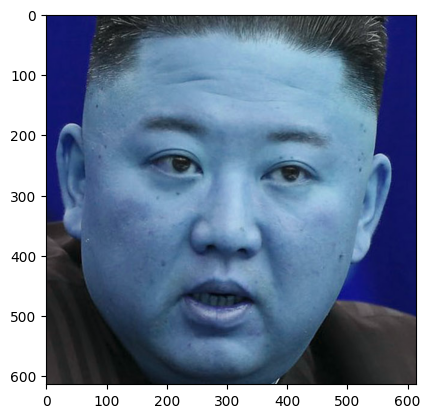

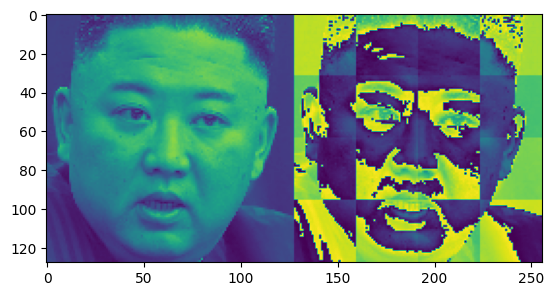

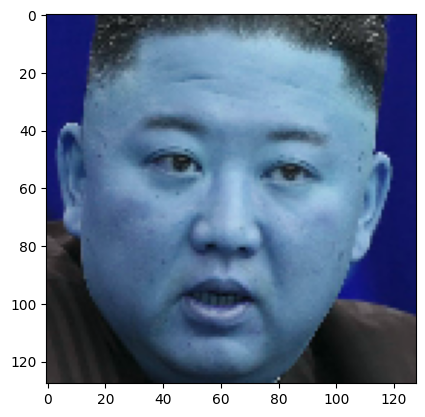

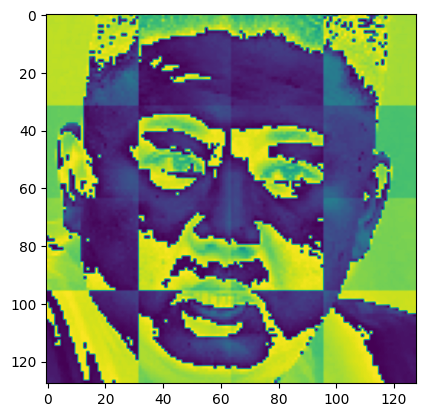

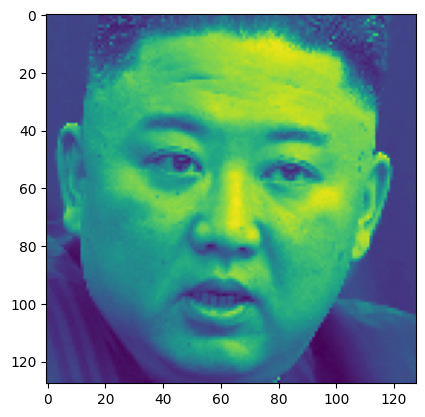

1 (128, 256)
(1, 128, 256)
(1, 128, 256, 1)
1/1 [==============================] - 0s 156ms/step
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
done
jin ping


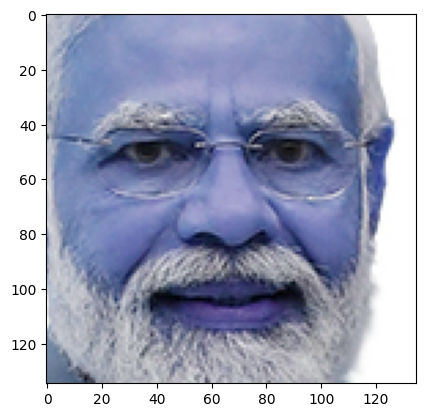

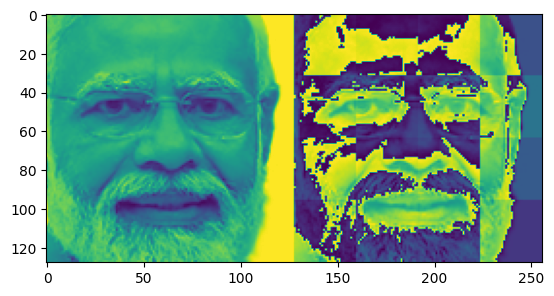

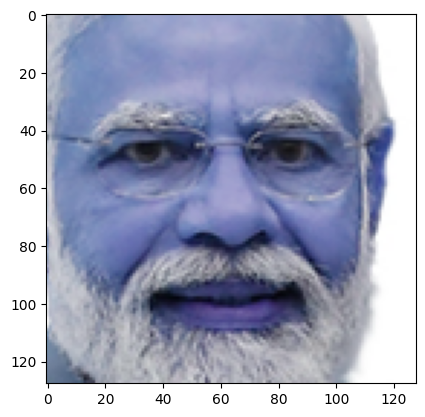

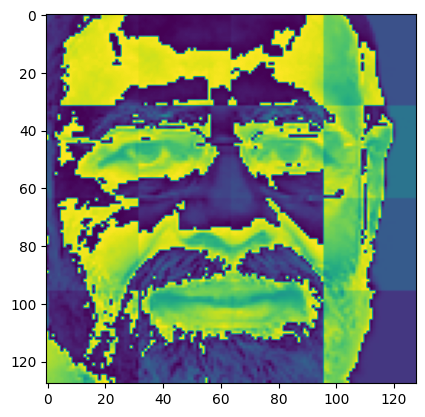

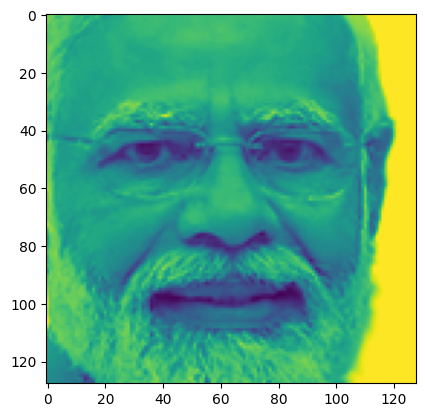

1 (128, 256)
(1, 128, 256)
(1, 128, 256, 1)
1/1 [==============================] - 0s 24ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
done
Modi


In [27]:
face = getFace('./politiciantest/kimtest.jpeg')
print(face)
face = getFace('./politiciantest/mot.jpg')
print(face)
